In [287]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [288]:
running_on_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') != 'Localhost'

if running_on_kaggle:
    print('Kaggle environment detected')
    data_dir = '/kaggle/input/food41/images/'
else:
    print('Running on localhost')
    data_dir = './dataset/food/images/'

Running on localhost


## Custom model analysis

In [308]:
img_width, img_height, batch_size = 180, 180, 64

In [309]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

In [310]:
train_data = train_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [311]:
class_dict  = train_data.class_indices
class_names = []
for cat in class_dict.keys():
    class_names.append(cat)
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [312]:
custom_model = keras.models.load_model('saved_models/custom_model')

In [313]:
def plot_prediction(img, model, label=None, rescale=False, softmax=False):
    plt.imshow(img)
    plt.show()
    img = np.expand_dims(img, axis=0)
    
    if rescale:
       img = img / 255.

    pred_vect = model.predict(img)

    if softmax:
        pred_vect = tf.nn.softmax(pred_vect).numpy()

    pred_idx_sorted  = np.argsort(pred_vect).flatten()
    proba_sorted     = np.sort(pred_vect).flatten()

    if label is not None:
        print("True label : ",class_names[label.argmax()])

    for i in range(1, 5):
        print(class_names[pred_idx_sorted[-i]]," predicted with proba " ,round(proba_sorted[-i] * 100, 3), "%")
    print("---------------------------------------------")

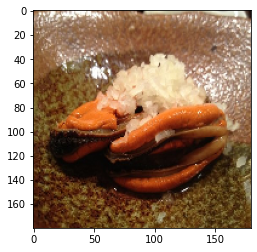

True label :  mussels
pancakes  predicted with proba  26.097 %
cannoli  predicted with proba  11.934 %
grilled_cheese_sandwich  predicted with proba  8.108 %
churros  predicted with proba  6.858 %
---------------------------------------------


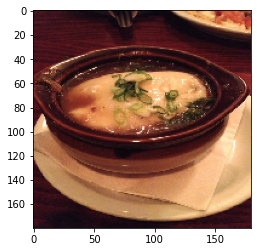

True label :  french_onion_soup
french_onion_soup  predicted with proba  22.186 %
lobster_bisque  predicted with proba  13.44 %
clam_chowder  predicted with proba  8.758 %
miso_soup  predicted with proba  7.149 %
---------------------------------------------


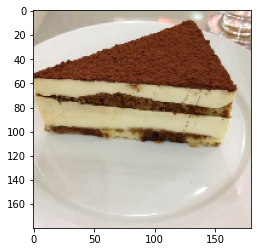

True label :  tiramisu
tiramisu  predicted with proba  83.633 %
cheesecake  predicted with proba  3.816 %
chocolate_cake  predicted with proba  3.208 %
peking_duck  predicted with proba  2.436 %
---------------------------------------------


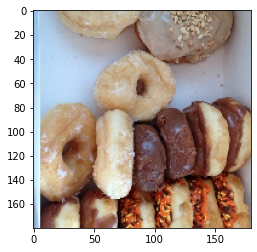

True label :  donuts
beignets  predicted with proba  15.522 %
donuts  predicted with proba  10.584 %
pulled_pork_sandwich  predicted with proba  10.0 %
onion_rings  predicted with proba  8.363 %
---------------------------------------------


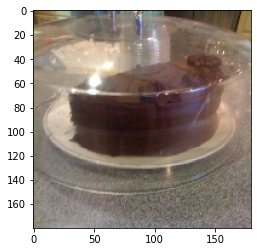

True label :  chocolate_cake
tiramisu  predicted with proba  26.395 %
red_velvet_cake  predicted with proba  23.476 %
chocolate_mousse  predicted with proba  20.384 %
chocolate_cake  predicted with proba  11.917 %
---------------------------------------------


In [314]:
for _ in range(5):
    random_batch = random.randint(0,31)
    random_img = random.randint(0,31)

    img_test = val_data[random_batch][0][random_img]
    label    = val_data[random_batch][1][random_img]
    plot_prediction(img_test, custom_model, label=label,softmax=True)

In [304]:
def find_missclassified(model, max_missclassified=9, softmax=False):
    missclassified = []
    max_batch = len(val_data)
    for batch in range(max_batch):
        for img_id in range(batch_size):
            img   = np.expand_dims(val_data[batch][0][img_id], axis=0)
            true_label = class_names[val_data[batch][1][img_id].argmax()]
            pred_vect = model.predict(img).flatten()

            if softmax:
                pred_vect = tf.nn.softmax(pred_vect).numpy()
            
            pred_label = class_names[pred_vect.argmax()]
            proba = round(pred_vect.max() * 100, 3) 
            if true_label != pred_label:
                missclassified.append({'true_label' : true_label, 
                                       'pred_label' : pred_label, 
                                       'proba'      : proba, 
                                       'img'        : img[0]
                                    })

            if len(missclassified) >= max_missclassified:
                return missclassified

    return missclassified

def plot_missclassified(missclassified):
    if len(missclassified) != 9:
        print("Bad length for missclassified, should be 9")
        print("actual length : ", len(missclassified))
    else:
        plt.figure(figsize=(10, 10))
        for i in range(len(missclassified)):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(missclassified[i]['img'])
            title = 'True : ' + missclassified[i]['true_label'] + \
                    '\n Predicted : ' + missclassified[i]['pred_label']
            plt.title(title)
            plt.axis("off")
        
        plt.show()

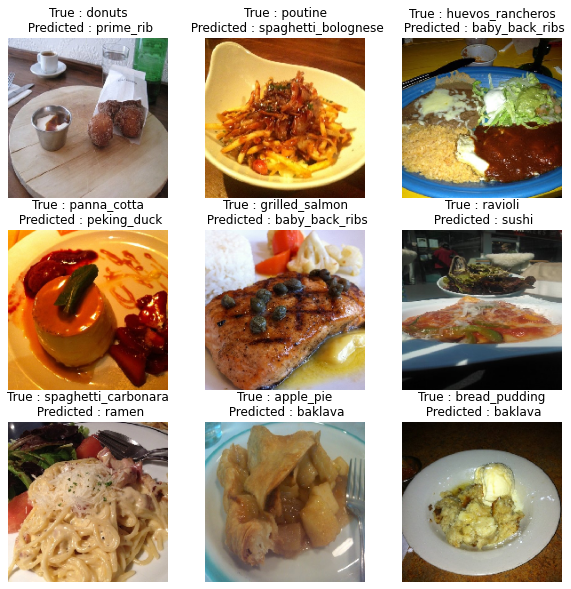

In [297]:
missclassified = find_missclassified(custom_model, softmax=True)
plot_missclassified(missclassified)

## Inception V3

In [298]:
batch_size = 32

img_height = 224
img_width = 224

In [299]:
train_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2)

test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2)

In [300]:
train_data = train_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

val_data = test_data_generator.flow_from_directory(
    data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation')

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


In [301]:
inveptionV3 = keras.models.load_model('saved_models/inceptionV3_15epochs')

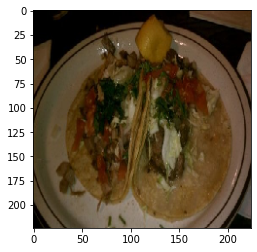

True label :  tacos
tacos  predicted with proba  96.129 %
huevos_rancheros  predicted with proba  1.829 %
shrimp_and_grits  predicted with proba  0.994 %
breakfast_burrito  predicted with proba  0.627 %
---------------------------------------------


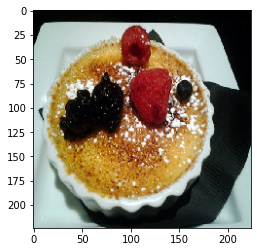

True label :  creme_brulee
creme_brulee  predicted with proba  100.0 %
pancakes  predicted with proba  0.0 %
chocolate_mousse  predicted with proba  0.0 %
hummus  predicted with proba  0.0 %
---------------------------------------------


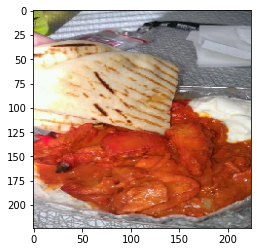

True label :  chicken_curry
chicken_curry  predicted with proba  99.964 %
breakfast_burrito  predicted with proba  0.009 %
chicken_quesadilla  predicted with proba  0.007 %
hummus  predicted with proba  0.005 %
---------------------------------------------


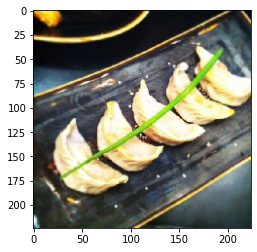

True label :  gyoza
gyoza  predicted with proba  91.743 %
dumplings  predicted with proba  8.205 %
deviled_eggs  predicted with proba  0.046 %
spring_rolls  predicted with proba  0.002 %
---------------------------------------------


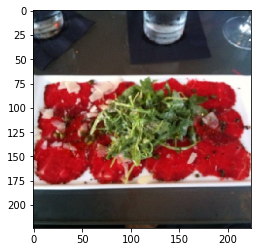

True label :  beef_carpaccio
beef_carpaccio  predicted with proba  100.0 %
caprese_salad  predicted with proba  0.0 %
ravioli  predicted with proba  0.0 %
beef_tartare  predicted with proba  0.0 %
---------------------------------------------


In [302]:
for _ in range(5):
    random_batch = random.randint(0,31)
    random_img = random.randint(0,31)

    img_test = val_data[random_batch][0][random_img]
    label    = val_data[random_batch][1][random_img]
    plot_prediction(img_test, inveptionV3, label=label)

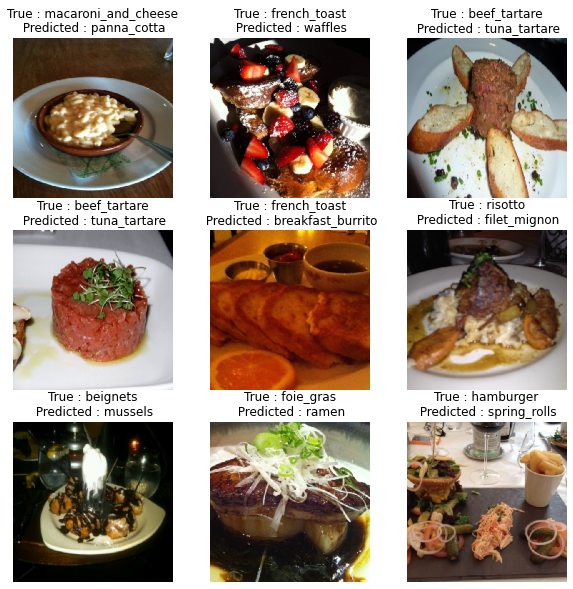

In [305]:
missclassified = find_missclassified(inveptionV3)
plot_missclassified(missclassified)